## Import necessary packages ##
## 載入必要的套件 ##

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
import tensorflow as tf
#from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

data_dir_path = './who-is-she/'
tf.keras.backend.clear_session()

## Retrieve target labels from mappings.txt file ##
## 把taget labels從Mappings裡面整理出來 ##

In [2]:
target_label_file_name = 'mapping.txt'
target_label_file_path = ''.join((data_dir_path,target_label_file_name))
with open(target_label_file_path) as f:
    all_lines = [line.split(', ') for line in f.read().splitlines()]
target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label
target_labels

{'rika': '0', 'risa': '1', 'yui': '2', 'akane': '3', 'neru': '4'}

## Set directory for training data ##
## 指定存放 train 資料集的資料夾 ##

In [3]:
## Set directory for training data ##
## 指定存放 train 資料集的資料夾 ### 指定存放 train 資料集的資料夾
train_dir = ''.join((data_dir_path, 'training_set'))
img_path_list = []
img_class_list = []
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.png'.format(train_dir, key)):
        img_class_list.append(target_labels[key])
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

In [4]:
data_list.head(20)

,class,path
0,0,./who-is-she/training_set/rika\000.png
1,0,./who-is-she/training_set/rika\001.png
2,0,./who-is-she/training_set/rika\002.png
3,0,./who-is-she/training_set/rika\003.png
4,0,./who-is-she/training_set/rika\004.png
5,0,./who-is-she/training_set/rika\005.png
6,0,./who-is-she/training_set/rika\006.png
7,0,./who-is-she/training_set/rika\007.png
8,0,./who-is-she/training_set/rika\008.png
9,0,./who-is-she/training_set/rika\009.png


## Make necessary datatype conversion ##
## 把data_list轉np array ##

In [ ]:
#把data_list轉np array
data_list_np = data_list.values
data_list_np.shape

### Retrieve image data from data_list_np 
### Resize and convert grayscale to rgb 
### 把image資料從data_list_np抓出來 ###
### 整理一下影像檔案 ###

In [5]:
#把image資料從data_list_np抓出來
image_data=[]
for i in range(len(data_list_np)):
    image_temp = cv2.imread(data_list_np[i][1])
    image_temp = cv2.resize(image_temp, (224, 224## Make necessary datatype conversion ##
## 把data_list轉np array ##))
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB)
    image_data.append(image_temp)

image_data_np = np.asarray(image_data)
image_data_np.shape

(538, 224, 224, 3)

In [6]:
#data_list.head()
class_label = data_list[['class']].copy()

class_label_np=class_label.values

print(type(class_label_np))

class_label_np = class_label_np.astype(int)

image_data_np.shape

<class 'numpy.ndarray'>


(538, 224, 224, 3)

In [7]:
class_label_lt=[]
for i in range(len(class_label_np)):
    class_label_lt.append(class_label_np[i][0])

#one-hot-encode
class_label_OneHot = np.eye(5)[class_label_lt]
#class_label_OneHot[0:5]
#class_label_OneHot.shape
X_train, X_valid, y_train, y_valid = train_test_split(image_data_np, class_label_OneHot, test_size = 0.1, stratify = class_label)

In [8]:
print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_valid.shape, y_valid.shape)

#Scaling the values
X_train = X_train/255.0
X_valid = X_valid/255.0

size of training data: (484, 224, 224, 3) (484, 5)
size of testing data: (54, 224, 224, 3) (54, 5)


### Import package and load DenseNet201 Model ###
### 載入套件並使用DenseNet201 模型 ###

In [9]:
num_classes=5
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201


model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(1-0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

### Train the model include ImageDataGenerator for Data augmentation ###
### 訓練模型包含資料增量 ###

In [11]:
epochs = 100
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
54/54 [==============================] - 3s 56ms/sample - loss: 1.7872 - acc: 0.1667

Epoch 00001: val_loss improved from inf to 1.76596, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 227s 7s/step - loss: 1.9425 - acc: 0.1983 - val_loss: 1.7660 - val_acc: 0.1667
Epoch 2/100
54/54 [==============================] - 0s 5ms/sample - loss: 1.6651 - acc: 0.1852

Epoch 00002: val_loss improved from 1.76596 to 1.65583, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 8s 268ms/step - loss: 1.7213 - acc: 0.2831 - val_loss: 1.6558 - val_acc: 0.1852
Epoch 3/100
54/54 [==============================] - 0s 5ms/sample - loss: 1.5677 - acc: 0.2222

Epoch 00003: val_loss improved from 1.65583 to 1.56372, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 8s 271ms/step - loss: 1.5996 - acc: 0.3636 - v

Epoch 25/100
54/54 [==============================] - 0s 5ms/sample - loss: 0.6607 - acc: 0.7778

Epoch 00025: val_loss improved from 0.68964 to 0.66527, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 8s 271ms/step - loss: 0.2669 - acc: 0.9360 - val_loss: 0.6653 - val_acc: 0.7778
Epoch 26/100
54/54 [==============================] - 0s 5ms/sample - loss: 0.6550 - acc: 0.7778

Epoch 00026: val_loss improved from 0.66527 to 0.65465, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 8s 270ms/step - loss: 0.2959 - acc: 0.9174 - val_loss: 0.6547 - val_acc: 0.7778
Epoch 27/100
54/54 [==============================] - 0s 5ms/sample - loss: 0.6345 - acc: 0.7593

Epoch 00027: val_loss improved from 0.65465 to 0.63401, saving model to ./saved_models/DenseNet201-Fine-Tune.h5
31/31 [==============================] - 8s 273ms/step - loss: 0.2908 - acc: 0.9277 - val_loss: 0.6340 - val_acc: 0.7593
Epoch 2

### Draw the picture and check the learning curve. It's quite obvious that the learning curve showing that it appears to be overfitting, meaning that DenseNet201 might just be too big for this data. ###
### 畫圖看看曲線，不難發現過了一定的epoch之後已經產生overfitting 的現象，代表DenseNet201 模型過於複雜 ###

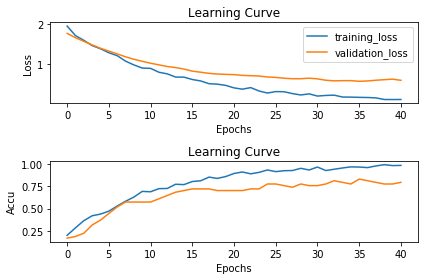

In [12]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.subplot(2,1,1)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel('Epochs')
plt.ylabel("Accu")
plt.title('Learning Curve')

plt.tight_layout()
plt.show()

In [13]:
from pathlib import Path,PurePosixPath
# 指定存放 test 資料集的資料夾
test_dir = ''.join((data_dir_path, 'testing_set/'))
test_img_path_list = []
for test_file_path in sorted(Path(test_dir).glob('*.png')):
    test_img_path_list.append(test_file_path)

#convert Posix obj to str
test_img_path_str = []
for i in range(len(test_img_path_list)):
    test_img_path_str.append(test_img_path_list[i].as_posix())

test_img_path_str[0]

test_img_path_str_np = np.asarray(test_img_path_str)

test_img_path_str_np.shape

test_str=[]
import re
for i in range(len(test_img_path_str)):
    test_str.append(re.findall("([A-Za-z0-9]+.png)",test_img_path_str[i]))

print(test_str[0])

['006F8606F6.png']


In [14]:
fullStr = ''.join([str(elem) for elem in test_str ])

fullStr_step1=fullStr.replace('\'][\'','')

fullStr_step2=fullStr_step1.replace('[\'','')

fullStr_step3=fullStr_step2.replace(']\'','')

test_path_id=''
for element in fullStr_step3:
    test_path_id+=element
id_test_list=test_path_id.split('.png') #.png

id_test_list.pop(438)

"']"

In [15]:
final_id_list=pd.DataFrame(id_test_list)

test_list = pd.DataFrame({'path': test_img_path_str_np})

test_list_np = test_list.values
test_list_np.shape

test_data=[]
for i in range(len(test_list_np)):
    testlist_temp = cv2.imread(test_list_np[i][0])
    testlist_temp = cv2.resize(testlist_temp, (224, 224))
    testlist_temp = cv2.cvtColor(testlist_temp, cv2.COLOR_BGR2RGB)
    test_data.append(testlist_temp)

In [16]:
test_data_np = np.asarray(test_data)
test_data_np = test_data_np / 255.0
test_data_np.astype('float32')
;

''

In [17]:
print(model_path)

./saved_models/DenseNet201-Fine-Tune.h5


In [18]:
model = load_model(model_path)
scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

54/54 [==============================] - 5s 86ms/sample - loss: 0.5581 - acc: 0.8333
Validation loss: 0.5580598734043263
Validation accuracy: 0.8333333


In [19]:
#直接load model的時候才需要重新宣告model_name跟path
#model_name = 'InceptionResNetV2'
#model_path = './saved_models/{}.h5'.format(model_name)
#model = load_model(model_path)
test_pred = model.predict(test_data_np)

y_test_pred = test_pred.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.asarray(id_test_list), 'class':y_test_pred}).sort_values(by='id')

y_test_pred_df.to_csv('{}.csv'.format(model_name), index=False)